# 1 - Introduction

## Business Problem & Interested Stakeholders

Where to open a restaurant in Lisbon?

This is the question that we will help to answer, understanding the actual configuration and possibilities using available data.
Lisbon is the capital city of Portugal and one of the most beautiful and charismatic cities of Europe.
It has a vibrant life with lots of people coming from suburbs to work and many tourists.
It is also well known by having a great climate and of course the great food.
Those who try to open a new restaurant face a great competition and challenge. 
All the help they can have is for sure wellcome.

This kind of knowledge can have a lot of interested stakeholders:
- Someone who wants to open a new restaurant and know the competition.
- Local authorities who want to better develop their municipalities.
- Real estate agents who want to get additional knowledge for their clients.
- Other intereste stakeholdes like students, foodies or just curious people.


# 2 - Data

On this section we will gather all the information needed to answer the question of this problem.

Since the new administrative reordering on 2013, Lisbon is divided into 24 borgoughs (freguesias in Portuguese). We will use this administrative division for our sutdy.

For this we need the following data:

- Coordinates to search from using the Foursquare API 
> Using the wikipedia page in which we can get the borough's coordinates: https://pt.wikipedia.org/wiki/Lisboa<br>

- Boroughs shapes to match with the venues location 
> Define in which borough the venue belongs, this information does not come from Foursquare API

    > https://geodados-cml.hub.arcgis.com/datasets/freguesias-2012?geometry=-9.315%2C38.702%2C-8.988%2C38.749&page=2&selectedAttribute=Shape__Length
    
- Aditional information by borough (population, population density, visiting population)
> It will be helpful for the final anaysis, use also wikipedia page: https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa
    
- Venues information 
> Use the Foursquare API to get explore the venues location and other relevant information


Import the libraries needed to this notebook

In [1]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap
from IPython.display import display


import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


### Get centroid coordinates for each borough from wikipedia pages

We are using a wikipedia page that has the links to pages for all Lisbon boroughs.

On that pages we can scrape the coordinates.

In [2]:
#URL for Lisbon page on wikipedia where there is a table with a link to each borough page with coordinates 
url = 'https://pt.wikipedia.org/wiki/Lisboa'

#get the page and scrape it with beautuful soup
html_data = requests.get(url).text

soup = BeautifulSoup(html_data, 'html5lib')

# print(soup.prettify())
#Find all tables on the page
tables = soup.find("body").find_all("table")

#Check the index of the table we need
# for i,row in enumerate(tables):
#     print("row",i,"is",row)
    
#Get the links
links = tables[12].find_all(href=True)

borough_name = []
borough_link = []
for i,row in enumerate(links):
    borough_name.append(row.text)
    borough_link.append('https://pt.wikipedia.org' + str(row.get('href')))
    
df_borough = pd.DataFrame(list(zip(borough_name,borough_link)), columns =['Borough', 'Link']) 
df_borough.head()

,Borough,Link
0,Ajuda,https://pt.wikipedia.org/wiki/Ajuda_(Lisboa)
1,Alcântara,https://pt.wikipedia.org/wiki/Alc%C3%A2ntara_(...
2,Alvalade,https://pt.wikipedia.org/wiki/Alvalade_(Lisboa)
3,Areeiro,https://pt.wikipedia.org/wiki/Areeiro_(Lisboa)
4,Arroios,https://pt.wikipedia.org/wiki/Arroios_(Lisboa)


The coordinates are in DMS format we need it on decimal, so we create a function for the conversion.

In [3]:
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'O':-1}
    new = old.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * direction[new_dir]

In [4]:
#Create empty lists
lat=[]
lon=[]

for x in range(24):
    page = requests.get(df_borough['Link'][x])
    coord = BeautifulSoup(page.content, 'html.parser').find('span', title='Mapas, fotos aéreas e outros dados para este local').find_all('span',style="white-space:nowrap" )
    lat.append(str(coord[0].text))
    lon.append(str(coord[1].text))
    
lat_dec = [conversion(x) for x in lat]
lon_dec = [conversion(x) for x in lon]
    
df_borough['Lat'] = lat_dec
df_borough['Lon'] = lon_dec
df_borough.drop(columns=['Link'],inplace=True)
df_borough.head()

,Borough,Lat,Lon
0,Ajuda,38.707500,-9.198333
1,Alcântara,38.706389,-9.174167
2,Alvalade,38.746944,-9.136111
3,Areeiro,38.740278,-9.128056
4,Arroios,38.728889,-9.138889


### Get population data for each borough from wikipedia page

I couldn't scrape the population data from the previous links. 

In this case there is another wikipedia page where we can get the info from.

In [5]:
#Get the table from wikipedia were population data for each borough is
url_lisboa = "https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa"
wiki_lisboa_url = requests.get(url_lisboa)
wiki_lisboa_data = pd.read_html(wiki_lisboa_url.text)
wiki_lisboa_data = wiki_lisboa_data[0]

#Table has a lot of duplicate rows, clean the information and put it on a dataframe
df_data = wiki_lisboa_data.iloc[:,2:4]
df_data.head()
df_data = df_data.rename(columns={"Freguesia (Zona)[1]": "Borough", "População[4]": "Population"})
df_data.columns = df_data.columns.droplevel()
df_data.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df_data = df_data.reindex(columns = df_data.columns.tolist() )
df_data.reset_index(inplace=True, drop= True)

#Some cleaning on the boroughs names and type conversions to help us with further calculations
df_data['Borough'] = df_data['Borough'].str.replace(r' \(.*\)','',regex=True)
df_data['Borough'] = df_data['Borough'].str.replace(r'\[.*\]','',regex=True)
df_data['Population'] = df_data['Population'].str.replace(r'[^0-9]+','',regex=True)
df_data['Population'] = df_data['Population'].astype(int)

#Merge the population dataframe with the coordinates dataframe
df_new = pd.merge(df_data, df_borough, on="Borough")
df_new.head()

,Borough,Population,Lat,Lon
0,Ajuda,15617,38.707500,-9.198333
1,Alcântara,13943,38.706389,-9.174167
2,Alvalade,31813,38.746944,-9.136111
3,Areeiro,20131,38.740278,-9.128056
4,Arroios,31653,38.728889,-9.138889


### Get shapes of each borough from a geojson file 

The Lisbon municipality has a geodata site where we can find a link to a geojson file with the shapes of each borough.

This will be very usefull to match the location of each venue with the correspondent borough.

Link to geodata site:
https://geodados-cml.hub.arcgis.com/datasets/freguesias-2012?geometry=-9.315%2C38.702%2C-8.988%2C38.749&page=2&selectedAttribute=Shape__Length

In [6]:
#Use the API link from the url above to get the geojson shapes file

geojson_url = 'https://opendata.arcgis.com/datasets/e0ebb7f5038e4114979f73cbf66321ef_1.geojson'
# !wget --quiet geojeson_url
lisbon_geo = 'lisbon_boroughs.geojson'
lisbon_shape = gpd.read_file(geojson_url)

#First of all get the centroids of the shapes to calculate the central coordinates, it's the best approach to get the nearby events
def getXY(pt):
    return (pt.x, pt.y)

centroidseries = lisbon_shape['geometry'].centroid
x,y = [list(t) for t in zip(*map(getXY, centroidseries))]


#Put the layer to a dataframe and add the centroids coordinates
df_json = pd.DataFrame(lisbon_shape)

df_json['Centroid_Lat'] = y
df_json['Centroid_Lon'] = x


df_json.drop(columns=['OBJECTID', 'COD_SIG', 'IDTIPO','PERIMETRO','FREGUESIAS53','GlobalID','Shape__Area','Shape__Length',],inplace=True)


df_json['AREA_M2'] = round(df_json['AREA_M2'] / 1000000,2) 


df_json.rename(columns={'AREA_M2': 'Area(km2)','NOME': 'Borough','geometry': 'Geometry',},inplace=True)

df_json.sort_values(by=['Borough'], axis=0, ascending=True, kind='quicksort', na_position='last', ignore_index=True, key=None, inplace=True)

df_json.head()

<ipython-input-6-b4e4144fc443>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidseries = lisbon_shape['geometry'].centroid


,Borough,Area(km2),Geometry,Centroid_Lat,Centroid_Lon
0,Ajuda,2.88,"POLYGON ((-9.19303 38.71619, -9.19295 38.71368...",38.712179,-9.198651
1,Alcântara,5.07,"POLYGON ((-9.17812 38.72376, -9.17800 38.72373...",38.709598,-9.183388
2,Alvalade,5.34,"POLYGON ((-9.12857 38.76302, -9.12859 38.76279...",38.753888,-9.146497
3,Areeiro,1.72,"POLYGON ((-9.12374 38.73866, -9.12477 38.73829...",38.741380,-9.133525
4,Arroios,2.13,"POLYGON ((-9.13306 38.73019, -9.13311 38.73008...",38.727657,-9.137940


Finally we merge the shapes and area dataframe with the population and coordinates.

We can now calculate the density population by borough. 

And we get our clean data set with all the borough information.

In [7]:
df_lisbon = pd.merge(df_new, df_json, on="Borough")
df_lisbon.head()
df_lisbon['Area(km2)'] = df_lisbon['Area(km2)'].astype(float)

df_lisbon["Density(per km2)"] = round(df_lisbon["Population"] / df_lisbon["Area(km2)"],1)


column_names = ['Borough', 'Population', 'Area(km2)', 'Density(per km2)', 'Lat', 'Lon','Geometry', 'Centroid_Lat', 'Centroid_Lon']

df_lisbon = df_lisbon.reindex(columns=column_names)
df_lisbon

,Borough,Population,Area(km2),Density(per km2),Lat,Lon,Geometry,Centroid_Lat,Centroid_Lon
0,Ajuda,15617,2.88,5422.6,38.707500,-9.198333,"POLYGON ((-9.19303 38.71619, -9.19295 38.71368...",38.712179,-9.198651
1,Alcântara,13943,5.07,2750.1,38.706389,-9.174167,"POLYGON ((-9.17812 38.72376, -9.17800 38.72373...",38.709598,-9.183388
2,Alvalade,31813,5.34,5957.5,38.746944,-9.136111,"POLYGON ((-9.12857 38.76302, -9.12859 38.76279...",38.753888,-9.146497
3,Areeiro,20131,1.72,11704.1,38.740278,-9.128056,"POLYGON ((-9.12374 38.73866, -9.12477 38.73829...",38.741380,-9.133525
4,Arroios,31653,2.13,14860.6,38.728889,-9.138889,"POLYGON ((-9.13306 38.73019, -9.13311 38.73008...",38.727657,-9.137940
5,Avenidas Novas,21625,2.99,7232.4,38.738889,-9.145833,"POLYGON ((-9.14758 38.74494, -9.14752 38.74464...",38.737465,-9.152328
6,Beato,12737,2.48,5135.9,38.734722,-9.105833,"POLYGON ((-9.12374 38.73866, -9.12323 38.73894...",38.731054,-9.110093
7,Belém,16528,10.43,1584.7,38.700000,-9.200000,"POLYGON ((-9.20591 38.71526, -9.20620 38.71482...",38.696207,-9.213136
8,Benfica,36985,8.02,4611.6,38.751111,-9.202222,"POLYGON ((-9.19402 38.75724, -9.19439 38.75657...",38.737746,-9.196363
9,Campo de Ourique,22120,1.65,13406.1,38.715278,-9.166944,"POLYGON ((-9.15764 38.72246, -9.15735 38.72230...",38.718542,-9.165753


# 3 - Methodology

## Data Exploration

In [8]:
latitude = 38.73124000000007
longitude = -9.162549999999953
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel


folium.GeoJson(lisbon_shape,
    style_function=lambda x: {
        'color' : 'red',
        'opacity': 0.6,
        'fillColor' : 'green',
        }).add_to(venues_map)


for lat, lng, label in zip(df_lisbon.Lat, df_lisbon.Lon, df_lisbon.Borough):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

for lat, lng, label in zip(df_lisbon.Centroid_Lat, df_lisbon.Centroid_Lon, df_lisbon.Borough):
    folium.Circle(
        [lat, lng],
        radius=100,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)
    

    
# display map
venues_map

### Use the Foursquare API

From previous map the centroid coordinates are a better location to choose from when request the venues from Foursquare API.
They can lead to better distribution, making less probable that a venue is not requested and also less duplicates.
Let's get the venues using thees coordinates as starting point.

In [9]:
CLIENT_ID = 'HRNBMKCTHF4U3FSPGFMW1OOOJUBXFU4DKVSBBIC1H0HBNRPF' # your Foursquare ID
CLIENT_SECRET = 'KYON45UZN50CJ2ICRF3SSSZHADF3HZCOZOVZHZ0WLEAR2Q5T' # your Foursquare Secret
VERSION = '20200605'
LIMIT = 100

In [15]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]
        
        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
lisbon_restaurants = getNearbyRestaurants(names=df_lisbon['Borough'],latitudes=df_lisbon['Centroid_Lat'],longitudes=df_lisbon['Centroid_Lon'],radius=1500)

In [17]:
lisbon_restaurants.shape

(1816, 7)

In [18]:
rest_unique = lisbon_restaurants.groupby(['Venue','Venue Latitude','Venue Longitude','Venue Category']).size().reset_index(name='Counts') 
print(rest_unique.shape)
rest_unique.head(10)

(1222, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Counts
0,100 Maneiras,38.714712,-9.144826,Restaurant,1
1,100 Montaditos,38.707056,-9.147182,Tapas Restaurant,2
2,100 Montaditos,38.772738,-9.092169,Tapas Restaurant,1
3,100% Hamburgueria,38.761268,-9.179715,Burger Joint,1
4,1001 Nights Iranian Restaurant,38.745068,-9.140761,Persian Restaurant,2
5,1300 Taberna,38.702888,-9.178968,Restaurant,2
6,2 à Esquina,38.720315,-9.137268,Portuguese Restaurant,1
7,39 Degraus,38.720479,-9.148769,Portuguese Restaurant,1
8,3º Anel,38.752660,-9.183155,Portuguese Restaurant,2
9,409,38.745979,-9.182975,Food,1


In [20]:
from shapely.geometry import shape, Point

rest_list = []

for ind1, rest in rest_unique.iterrows():
    point = Point(rest[["Venue Longitude"]].item(), rest[["Venue Latitude"]].item())
    for ind2, borough in df_lisbon.iterrows():
        polygon = shape(borough[["Geometry"]].item())
        if (polygon.contains(point)):
            frame = {'Borough': borough[["Borough"]].item(),'Borough Latitude': borough[["Centroid_Lat"]].item(),
                     'Borough Longitude': borough[["Centroid_Lon"]].item(), 'Venue': rest[["Venue"]].item(), 
                     'Venue Latitude': rest[["Venue Latitude"]].item(), 'Venue Longitude': rest[["Venue Longitude"]].item(), 
                     'Venue Category': rest[["Venue Category"]].item()    
                    }
            rest_list.append(frame)

col = ['Borough', 'Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
lisbon_restaurants_unique = pd.DataFrame(rest_list, columns = col)
lisbon_restaurants_unique.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Misericórdia,38.705446,-9.146674,100 Maneiras,38.714712,-9.144826,Restaurant
1,Misericórdia,38.705446,-9.146674,100 Montaditos,38.707056,-9.147182,Tapas Restaurant
2,Parque das Nações,38.774806,-9.095478,100 Montaditos,38.772738,-9.092169,Tapas Restaurant
3,Carnide,38.765200,-9.186734,100% Hamburgueria,38.761268,-9.179715,Burger Joint
4,Areeiro,38.741380,-9.133525,1001 Nights Iranian Restaurant,38.745068,-9.140761,Persian Restaurant


In [21]:
df = lisbon_restaurants_unique.groupby('Borough').size().reset_index(name='Count') 
df.sort_values(by='Count', ascending=False)


,Borough,Count
5,Avenidas Novas,98
13,Lumiar,86
20,Santa Maria Maior,82
7,Belém,70
12,Estrela,69
21,Santo António,69
15,Misericórdia,68
2,Alvalade,65
22,São Domingos de Benfica,65
16,Olivais,64


In [22]:
rest_map = folium.Map([latitude, longitude], zoom_start=12)

folium.GeoJson(lisbon_shape,
    style_function=lambda x: {
        'color' : 'red',
        'opacity': 0.6,
        'fillColor' : 'green',
        }).add_to(rest_map)

for label, lat, lng in zip(lisbon_restaurants_unique['Venue'], 
                           lisbon_restaurants_unique['Venue Latitude'], 
                           lisbon_restaurants_unique['Venue Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        colur='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False
    ).add_to(rest_map)
    


from IPython.display import display
display(rest_map)

There are some categories that are not restaurant, we must remove them.
Those are not competition.


In [23]:
lisbon_restaurants_unique['Venue Category'].unique()

array(['Restaurant', 'Tapas Restaurant', 'Burger Joint',
       'Persian Restaurant', 'Portuguese Restaurant', 'Food',
       'Seafood Restaurant', 'Buffet', 'Steakhouse', 'Café', 'Bakery',
       'Peruvian Restaurant', 'Snack Place', 'Italian Restaurant',
       'Eastern European Restaurant', 'Ramen Restaurant',
       'Mediterranean Restaurant', 'Vegetarian / Vegan Restaurant',
       'Middle Eastern Restaurant', 'BBQ Joint', 'Breakfast Spot',
       'Indian Restaurant', 'Sushi Restaurant', 'Brazilian Restaurant',
       'Japanese Restaurant', 'Burrito Place', 'Cafeteria',
       'Empanada Restaurant', 'Sandwich Place', 'Bistro',
       'Swiss Restaurant', 'Chinese Restaurant', 'Asian Restaurant',
       'South American Restaurant', 'Pizza Place',
       'Cajun / Creole Restaurant', 'Fast Food Restaurant',
       'Argentinian Restaurant', 'Comfort Food Restaurant', 'Gastropub',
       'Modern European Restaurant', 'Deli / Bodega', 'French Restaurant',
       'South Indian Restaurant'

In [24]:
cat_remove= ['Café','Bakery','Snack Place','Breakfast Spot','Sandwich Place','Cafeteria','Gastropub','Bistro','Creperie','Poke Place','Soup Place', 'Bagel Shop']
lisbon_restaurants = lisbon_restaurants_unique[~lisbon_restaurants_unique['Venue Category'].isin(cat_remove)]
lisbon_restaurants.shape

(895, 7)

In [25]:
venueDF = lisbon_restaurants.groupby('Venue Category').size().reset_index(name='Counts')
venueDF.sort_values(by=['Counts'], ascending=False).head(10)

,Venue Category,Counts
42,Portuguese Restaurant,249
44,Restaurant,149
32,Italian Restaurant,39
41,Pizza Place,37
8,Burger Joint,36
31,Indian Restaurant,29
47,Seafood Restaurant,29
5,BBQ Joint,28
52,Sushi Restaurant,27
34,Mediterranean Restaurant,27


#### Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [27]:
lisbon_onehot = pd.get_dummies(lisbon_restaurants['Venue Category'])
lisbon_onehot.insert(loc=0, column='Borough', value=lisbon_restaurants['Borough'])
lisbon_grouped = lisbon_onehot.groupby('Borough').mean().reset_index()
lisbon_grouped.head()

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Buffet,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Noodle House,Persian Restaurant,Peruvian Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Ajuda,0.0,0.0,0.000000,0.000000,0.0,0.181818,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.181818,0.000000,0.545455,0.0,0.0,0.090909,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,Alcântara,0.0,0.0,0.032258,0.000000,0.0,0.032258,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.032258,0.000000,0.0,0.0,0.032258,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.064516,0.000000,0.129032,0.0,0.000000,0.0,0.0,0.000000,0.0,0.064516,0.129032,0.000000,0.419355,0.0,0.0,0.032258,0.0,0.000000,0.0,0.032258,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,Alvalade,0.0,0.0,0.000000,0.037037,0.0,0.018519,0.018519,0.0,0.055556,0.0,0.0,0.0,0.055556,0.000000,0.018519,0.0,0.0,0.000000,0.000000,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018519,0.055556,0.074074,0.018519,0.018519,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037037,0.370370,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.0,0.018519,0.037037,0.0,0.0,0.018519,0.000000,0.0
3,Areeiro,0.0,0.0,0.047619,0.000000,0.0,0.047619,0.000000,0.0,0.095238,0.0,0.0,0.0,0.047619,0.000000,0.047619,0.0,0.0,0.000000,0.047619,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.047619,0.047619,0.095238,0.000000,0.047619,0.0,0.000000,0.0,0.0,0.047619,0.0,0.000000,0.142857,0.000000,0.190476,0.0,0.0,0.047619,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,Arroios,0.0,0.0,0.000000,0.000000,0.0,0.021277,0.042553,0.0,0.042553,0.0,0.0,0.0,0.021277,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.000000,0.127660,0.021277,0.042553,0.021277,0.0,0.021277,0.0,0.0,0.000000,0.0,0.021277,0.276596,0.021277,0.106383,0.0,0.0,0.042553,0.0,0.021277,0.0,0.021277,0.021277,0.0,0.0,0.000000,0.085106,0.0


#### Organize by most common venue

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lisbon_venues_sorted = pd.DataFrame(columns=columns)
lisbon_venues_sorted['Borough'] = lisbon_grouped['Borough']

for ind in np.arange(lisbon_grouped.shape[0]):
    lisbon_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lisbon_grouped.iloc[ind, :], num_top_venues)

In [30]:
lisbon_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Restaurant,BBQ Joint,Portuguese Restaurant,Seafood Restaurant,African Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,Alcântara,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Pizza Place,Italian Restaurant,BBQ Joint,Comfort Food Restaurant,Seafood Restaurant,Argentinian Restaurant,Eastern European Restaurant
2,Alvalade,Portuguese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Burger Joint,Indian Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Fast Food Restaurant
3,Areeiro,Restaurant,Portuguese Restaurant,Italian Restaurant,Burger Joint,Chinese Restaurant,Indian Restaurant,Hot Dog Joint,Persian Restaurant,Empanada Restaurant,Mediterranean Restaurant
4,Arroios,Portuguese Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Brazilian Restaurant,Burger Joint,Seafood Restaurant,South Indian Restaurant,Pizza Place


## Machine Learning - Clustering

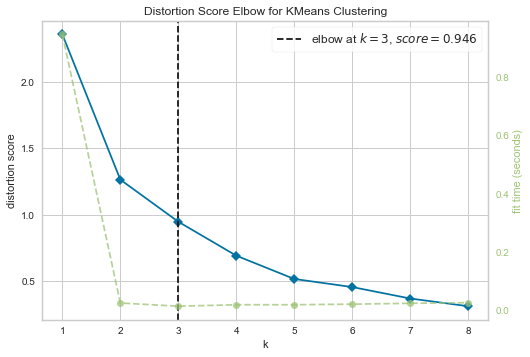

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

lisbon_part_clustering = lisbon_grouped.drop('Borough', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(lisbon_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

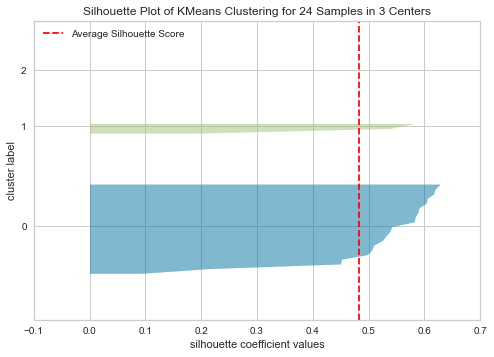

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 24 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
model = KMeans(3, random_state=2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(lisbon_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [39]:
# set number of clusters
kclusters = 4

lisbon_grouped_clustering = lisbon_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lisbon_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 3, 0, 2, 2,
       1, 2])

In [41]:
lisbon_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)
lisbon_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
lisbon_venues_sorted.head()

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Ajuda,Restaurant,BBQ Joint,Portuguese Restaurant,Seafood Restaurant,African Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,1,Alcântara,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Pizza Place,Italian Restaurant,BBQ Joint,Comfort Food Restaurant,Seafood Restaurant,Argentinian Restaurant,Eastern European Restaurant
2,2,Alvalade,Portuguese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Burger Joint,Indian Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Fast Food Restaurant
3,1,Areeiro,Restaurant,Portuguese Restaurant,Italian Restaurant,Burger Joint,Chinese Restaurant,Indian Restaurant,Hot Dog Joint,Persian Restaurant,Empanada Restaurant,Mediterranean Restaurant
4,2,Arroios,Portuguese Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Brazilian Restaurant,Burger Joint,Seafood Restaurant,South Indian Restaurant,Pizza Place


In [42]:
lisbon_merged = df_lisbon.join(lisbon_venues_sorted.set_index('Borough'), on='Borough')
# lisbon_merged['Cluster Labels'] = lisbon_merged['Cluster Labels'].fillna(0)
# lisbon_merged['Cluster Labels'] = lisbon_merged['Cluster Labels'].astype(int)
lisbon_merged.drop(columns=['Geometry','Lat', 'Lon'], inplace=True)

lisbon_merged.head() 

,Borough,Population,Area(km2),Density(per km2),Centroid_Lat,Centroid_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,15617,2.88,5422.6,38.712179,-9.198651,0,Restaurant,BBQ Joint,Portuguese Restaurant,Seafood Restaurant,African Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,Alcântara,13943,5.07,2750.1,38.709598,-9.183388,1,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Pizza Place,Italian Restaurant,BBQ Joint,Comfort Food Restaurant,Seafood Restaurant,Argentinian Restaurant,Eastern European Restaurant
2,Alvalade,31813,5.34,5957.5,38.753888,-9.146497,2,Portuguese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Burger Joint,Indian Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Fast Food Restaurant
3,Areeiro,20131,1.72,11704.1,38.741380,-9.133525,1,Restaurant,Portuguese Restaurant,Italian Restaurant,Burger Joint,Chinese Restaurant,Indian Restaurant,Hot Dog Joint,Persian Restaurant,Empanada Restaurant,Mediterranean Restaurant
4,Arroios,31653,2.13,14860.6,38.727657,-9.137940,2,Portuguese Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Brazilian Restaurant,Burger Joint,Seafood Restaurant,South Indian Restaurant,Pizza Place


# 4 - Result and Discussion

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

 

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lisbon_merged['Centroid_Lat'], lisbon_merged['Centroid_Lon'], lisbon_merged['Borough'], lisbon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
    
map_clusters

In [44]:
count_venue = lisbon_merged[['Cluster Labels','1st Most Common Venue']]

count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')
count_venue
#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Portuguese Restaurant,Restaurant,Wings Joint
0,0,3,0
1,2,6,0
2,12,0,0
3,0,0,1


Text(0, 0.5, 'Venues count')

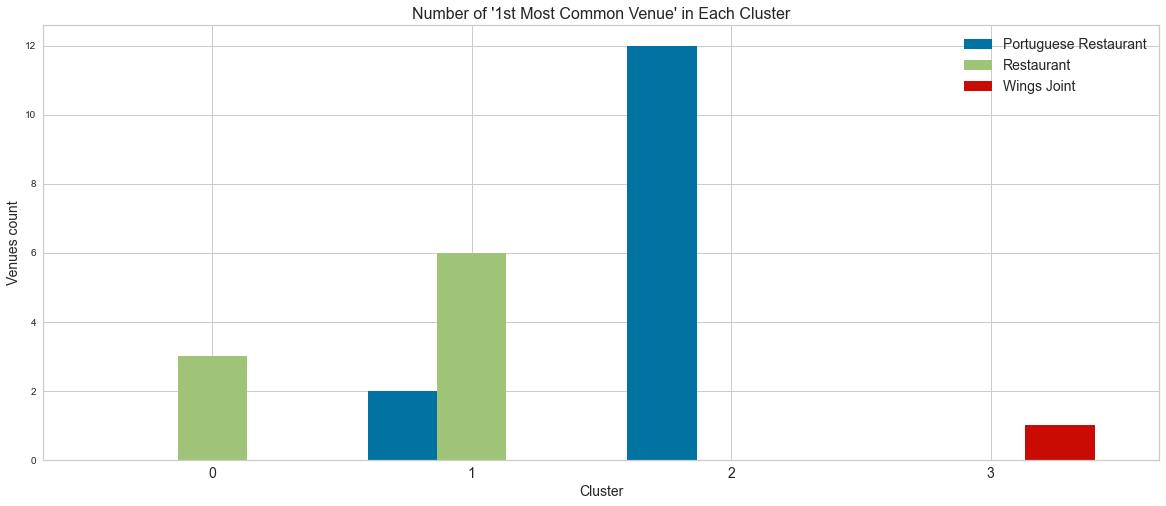

In [45]:
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of '1st Most Common Venue' in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Venues count', fontsize=14)

In [46]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 0, lisbon_merged.columns[[0] + list(range(4, lisbon_merged.shape[1]))]]

,Borough,Centroid_Lat,Centroid_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,38.712179,-9.198651,0,Restaurant,BBQ Joint,Portuguese Restaurant,Seafood Restaurant,African Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
6,Beato,38.731054,-9.110093,0,Restaurant,BBQ Joint,Portuguese Restaurant,African Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant
19,Santa Clara,38.785163,-9.152169,0,Restaurant,Ramen Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Noodle House


In [47]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 1, lisbon_merged.columns[[0] + list(range(4, lisbon_merged.shape[1]))]]

,Borough,Centroid_Lat,Centroid_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alcântara,38.709598,-9.183388,1,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Pizza Place,Italian Restaurant,BBQ Joint,Comfort Food Restaurant,Seafood Restaurant,Argentinian Restaurant,Eastern European Restaurant
3,Areeiro,38.741380,-9.133525,1,Restaurant,Portuguese Restaurant,Italian Restaurant,Burger Joint,Chinese Restaurant,Indian Restaurant,Hot Dog Joint,Persian Restaurant,Empanada Restaurant,Mediterranean Restaurant
5,Avenidas Novas,38.737465,-9.152328,1,Restaurant,Portuguese Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Steakhouse,Pizza Place,Indian Restaurant,Burger Joint,Sushi Restaurant
13,Lumiar,38.769795,-9.163491,1,Restaurant,Portuguese Restaurant,Pizza Place,Tapas Restaurant,Fast Food Restaurant,Sushi Restaurant,Chinese Restaurant,Mediterranean Restaurant,Brazilian Restaurant,Japanese Restaurant
14,Marvila,38.747934,-9.110954,1,Restaurant,Portuguese Restaurant,Argentinian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Tapas Restaurant,Indian Restaurant,Buffet,Pizza Place,Cantonese Restaurant
16,Olivais,38.771035,-9.124650,1,Restaurant,Portuguese Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,BBQ Joint,Salad Place,Food,Falafel Restaurant,Japanese Restaurant
17,Parque das Nações,38.774806,-9.095478,1,Portuguese Restaurant,Burger Joint,Seafood Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Sushi Restaurant,Steakhouse,Restaurant,Italian Restaurant,Tapas Restaurant
22,São Domingos de Benfica,38.746451,-9.176373,1,Portuguese Restaurant,BBQ Joint,Burger Joint,Restaurant,Pizza Place,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Food


In [48]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 2, lisbon_merged.columns[[0] + list(range(4, lisbon_merged.shape[1]))]]

,Borough,Centroid_Lat,Centroid_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alvalade,38.753888,-9.146497,2,Portuguese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Burger Joint,Indian Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Fast Food Restaurant
4,Arroios,38.727657,-9.137940,2,Portuguese Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Brazilian Restaurant,Burger Joint,Seafood Restaurant,South Indian Restaurant,Pizza Place
7,Belém,38.696207,-9.213136,2,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Seafood Restaurant,BBQ Joint,Food Truck,Burger Joint,Diner,Chinese Restaurant
8,Benfica,38.737746,-9.196363,2,Portuguese Restaurant,Restaurant,Seafood Restaurant,BBQ Joint,Burger Joint,Sushi Restaurant,Mediterranean Restaurant,Food Truck,Pizza Place,Mexican Restaurant
9,Campo de Ourique,38.718542,-9.165753,2,Portuguese Restaurant,Seafood Restaurant,Restaurant,Steakhouse,Japanese Restaurant,Dim Sum Restaurant,Italian Restaurant,Sushi Restaurant,Burger Joint,Indian Restaurant
10,Campolide,38.731158,-9.167270,2,Portuguese Restaurant,Japanese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Brazilian Restaurant,African Restaurant,Ramen Restaurant,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant
11,Carnide,38.765200,-9.186734,2,Portuguese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Fast Food Restaurant,Seafood Restaurant,Dim Sum Restaurant,Indian Restaurant
12,Estrela,38.703768,-9.163458,2,Portuguese Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,BBQ Joint,Tapas Restaurant,Steakhouse
15,Misericórdia,38.705446,-9.146674,2,Portuguese Restaurant,Restaurant,Tapas Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Burger Joint,Peruvian Restaurant,Pizza Place,Food Court,Mediterranean Restaurant
20,Santa Maria Maior,38.708311,-9.132404,2,Portuguese Restaurant,Restaurant,Indian Restaurant,Mediterranean Restaurant,Tapas Restaurant,Peruvian Restaurant,Chinese Restaurant,Seafood Restaurant,Argentinian Restaurant,Vegetarian / Vegan Restaurant


In [49]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 3, lisbon_merged.columns[[0] + list(range(4, lisbon_merged.shape[1]))]]

,Borough,Centroid_Lat,Centroid_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Penha de França,38.726432,-9.120539,3,Wings Joint,Indian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Noodle House


# 5 - Conclusion

The analysis was done using Fousquare API and geographical information of Lisbon boroughs.

Information was acquired on different sources and different techniques: scraping web, importing geojson.

The information for the restaurants was obtained though Foursquare API.

Data cleaning was used to prepare data for machine learning algorithm.

A clustering algorithm, k-means was used to cluster the boroughs using the most common categories of restaurants.

Finally visualizing the clusters on Lisbon map and exploring a specific cluster can give our stakeholders some usefull insights.

More and insights can be obtained enriching the analysis with further developments.


# 6 - Next Developments

Next steps to develop the study:

Upgrading the amount of information, for example: 
- Home sales/Rental prices
- People movement around the city
- Distance to market suppliers 

Use a different Venue API with more data. 

Try different machine learning algorithms.